In [1]:
''' Ensemble Experiment - Darius Farokhi'''
import pymysql
import pandas as pd
import glob
import os
import numpy as np

#(1) combine 36 months of crime data 09/2018 - 08/2021
path = r'C:\Users\pigle\OneDrive\Documents\Business Analytics\MSc Project\Raw_Data_allYears' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join as this makes concatenation OS independent

df_from_each_file = (pd.read_csv(f) for f in all_files)
df   = pd.concat(df_from_each_file, ignore_index=True) # doesn't create a list, nor does it append to one
#df.to_excel('combined_file.xlsx')
import matplotlib.pyplot as plt
import seaborn as sns 
df.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,NaN,2018-09,Merseyside Police,Merseyside Police,-2.711600,53.383635,On or near Camberwell Park Road,E01012392,Halton 001A,Anti-social behaviour,NaN,NaN
1,0111ce2b17f7bb96f29fe70a7a06afd1490eb05f3c8683...,2018-09,Merseyside Police,Merseyside Police,-2.747770,53.389499,On or near Cronton Road,E01012393,Halton 001B,Vehicle crime,Unable to prosecute suspect,NaN
2,NaN,2018-09,Merseyside Police,Merseyside Police,-2.849802,53.490299,On or near Depot Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
3,NaN,2018-09,Merseyside Police,Merseyside Police,-2.872402,53.484743,On or near Quarryside Drive,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN
4,NaN,2018-09,Merseyside Police,Merseyside Police,-2.870599,53.485736,On or near Darmond Road,E01006448,Knowsley 001A,Anti-social behaviour,NaN,NaN


In [2]:
#(2) HDDBSCAN of highest crime density
import hdbscan
%matplotlib inline
## clean and transform data for spatial clustering
coords = df.loc[:,['Latitude', 'Longitude','Month']] 
coords2 = coords[coords['Month'] == '2021-08']
coords2= coords2.drop(columns=['Month'])
coords2=coords2[['Longitude','Latitude']]
coords_array = coords2[['Longitude','Latitude']].to_numpy()

clusterer = hdbscan.HDBSCAN(min_cluster_size=300, min_samples=15, prediction_data=True).fit(coords_array)
clusters= np.asarray(clusterer.labels_)
clusterer.labels_
print('Number of Clusters:',clusterer.labels_.max())
print('Cluster probabilities:', clusterer.probabilities_)

Number of Clusters: 11
Cluster probabilities: [0. 0. 1. ... 0. 0. 0.]


Text(0.5, 1.0, 'HDBSCAN 08-2021')

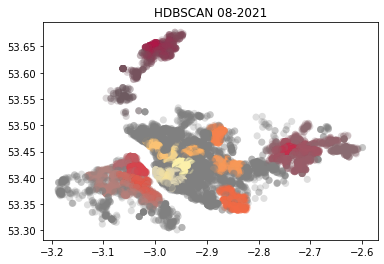

In [3]:
##visualise through different colors
color_palette = sns.color_palette('Spectral', 25)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*coords_array.T, s=50, linewidths=0, c=cluster_member_colors, alpha=0.25)
plt.title('HDBSCAN 08-2021')

In [4]:
#(3) Apply forecasting to high density areas from clustering
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
alpha = 0.6

## connect py to SQL database
connection = pymysql.connect(host='13.95.205.101',
user='Dawson',
password='123456',
database='crime',
cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = "SELECT COUNT(*) AS crime_number FROM window WHERE MSOA_code IN ('E02006932', 'E02006933', 'E02006934') GROUP BY crime_date ORDER BY crime_date;"
    cursor.execute(sql)
    result = cursor.fetchall()
    connection.commit()
    df_central = pd.DataFrame(result)

#Total = df_central['crime_number'].sum() ## MSc related descriptor
#print(Total)

connection = pymysql.connect(host='13.95.205.101',
user='Dawson',
password='123456',
database='crime',
cursorclass=pymysql.cursors.DictCursor)
with connection.cursor() as cursor:
    sql = "SELECT COUNT(*) AS crime_number FROM window WHERE MSOA_code IN ('E02001482', 'E02001487', 'E02001488') GROUP BY crime_date ORDER BY crime_date;"
    cursor.execute(sql)
    result2 = cursor.fetchall()
    connection.commit()
    df_central2 = pd.DataFrame(result2)

#Total2 = df_central2['crime_number'].sum()
#print(Total2)

C:\Users\pigle\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


Liverpool central RMSE 193.61202286461634
Birkenhead central RMSE 42.198813005919384


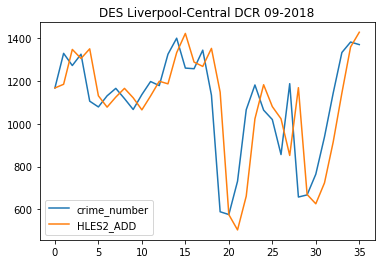

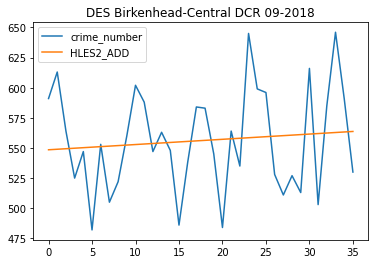

In [5]:
## compute, visualise and error evaluate double exponential smoothing forecasting
df_central['HLES2_ADD'] = ExponentialSmoothing(df_central['crime_number'],trend='add', seasonal=None).fit().fittedvalues
df_central2['HLES2_ADD'] = ExponentialSmoothing(df_central2['crime_number'],trend='add', seasonal=None).fit().fittedvalues

df_central[['crime_number','HLES2_ADD']].plot(title='DES Liverpool-Central DCR 09-2018')

df_central2[['crime_number','HLES2_ADD']].plot(title='DES Birkenhead-Central DCR 09-2018')

rms = mean_squared_error(df_central['crime_number'], df_central['HLES2_ADD'], squared=False)
print('Liverpool central RMSE', (rms))

rms2 = mean_squared_error(df_central2['crime_number'], df_central2['HLES2_ADD'], squared=False)
print('Birkenhead central RMSE',(rms2))